# HW 4 - Acquiring data

## Task 1. HDF to CSV conversion
Create a script to automatically convert data stored in the netCDF format in the "Data/LS_MS Data CDF" to the CSV format. Output files should be equivalent to the files in the "Data/LS_MS Data CSV" folder.

In [3]:
import netCDF4 as nc
import pandas as pd
import os
from pathlib import Path

input_dir = "../Data/LS_MS Data CDF"
output_dir = "../Data/LS_MS Data CSV"


def test_cdf_file(nc_file_path):
    try:
        dataset = nc.Dataset(nc_file_path, 'r')
        print(f"Successfully opened {nc_file_path} as netCDF")
        print("Variables:", list(dataset.variables.keys()))
        dataset.close()
        return True
    except Exception as e:
        print(f"Failed to open {nc_file_path} with netCDF4: {str(e)}")
        return False


def convert_nc_to_csv(nc_file_path, output_csv_path):
    try:
        dataset = nc.Dataset(nc_file_path, 'r')
        data_dict = {}

        for var_name in dataset.variables:
            data = dataset.variables[var_name][:]

            if data.ndim > 1:
                data = data.flatten()
            data_dict[var_name] = data

        lengths = [len(v) for v in data_dict.values()]
        if lengths and not all(l == lengths[0] for l in lengths):
            min_length = min(lengths)
            for key in data_dict:
                data_dict[key] = data_dict[key][:min_length]

        df = pd.DataFrame(data_dict)
        df.to_csv(output_csv_path, index=False)
        dataset.close()
        
        print(f"Successfully converted: {nc_file_path} -> {output_csv_path}")
        return True
    
    except Exception as e:
        print(f"Error converting {nc_file_path}: {str(e)}")
        return False


def process_all_files():
    cdf_files = list(Path(input_dir).glob('*.CDF'))  # Adjust to *.cdf if needed
    
    if not cdf_files:
        print("No .CDF files found in the input directory")
        return
    
    print(f"Found {len(cdf_files)} CDF files to process")
    
    if cdf_files:
        test_cdf_file(str(cdf_files[0]))
    
    for cdf_file in cdf_files:
        csv_filename = cdf_file.stem + '.csv'
        output_path = os.path.join(output_dir, csv_filename)
        convert_nc_to_csv(str(cdf_file), output_path)


def verify_conversion():
    csv_files = list(Path(output_dir).glob('*.csv'))
    print(f"\nConversion Summary:")
    print(f"Number of CSV files created: {len(csv_files)}")
    
    if csv_files:
        sample_csv = csv_files[0]
        df = pd.read_csv(sample_csv)
        print(f"Sample of {sample_csv.name}:")
        print(df.head())


process_all_files()
verify_conversion()

Found 735 CDF files to process
Successfully opened ../Data/LS_MS Data CDF/2015_SEP_18_LUBA_5T3_MRM_TABL_M1_C13L_CYS.CDF as netCDF
Variables: ['error_log', 'a_d_sampling_rate', 'a_d_coaddition_factor', 'scan_acquisition_time', 'scan_duration', 'inter_scan_time', 'resolution', 'actual_scan_number', 'total_intensity', 'mass_range_min', 'mass_range_max', 'time_range_min', 'time_range_max', 'scan_index', 'point_count', 'flag_count', 'mass_values', 'intensity_values', 'instrument_name', 'instrument_id', 'instrument_mfr', 'instrument_model', 'instrument_serial_no', 'instrument_sw_version', 'instrument_fw_version', 'instrument_os_version', 'instrument_app_version', 'instrument_comments']
Successfully converted: ../Data/LS_MS Data CDF/2015_SEP_18_LUBA_5T3_MRM_TABL_M1_C13L_CYS.CDF -> ../Data/LS_MS Data CSV/2015_SEP_18_LUBA_5T3_MRM_TABL_M1_C13L_CYS.csv
Successfully converted: ../Data/LS_MS Data CDF/2015_SEP_18_LUBA_5T3_MRM_TABL_M3_C13L_GLY.CDF -> ../Data/LS_MS Data CSV/2015_SEP_18_LUBA_5T3_MRM_TA

## Task 2. LS/MS Data exploration
Use netCDF4 library to explore the contents of the ".CDF" files from the "Data/LS_MS Data CDF". Try to extract the following information:
1. All the information about the instrument, which was used to collect the data.
2. All time-series related data. Try to figure out how data is stored.

In [15]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt


def load_cdf_file(file_path):
    try:
        dataset = nc.Dataset(file_path, 'r')
        print("File loaded successfully.")
        print("File Format:", dataset.file_format)
        return dataset
    except Exception as e:
        print(f"Error loading file: {e}")
        return None


def extract_instrument_info(dataset):
    print("\n=== Instrument-Related Metadata ===")
    # Global attributes
    for attr in dataset.ncattrs():
        print(f"{attr}: {dataset.getncattr(attr)}")

    instrument_vars = [var for var in dataset.variables if 'instrument' in var.lower()]
    if instrument_vars:
        print("\nInstrument-Specific Variables:")
        for var in instrument_vars:
            print(f"{var}: {dataset.variables[var][:]}")
    else:
        print("\nNo variables explicitly named with 'instrument' found.")


def explore_time_series(dataset):
    print("\n=== Time-Series Data Exploration ===")
    # Possible time variable names
    time_vars_candidates = ['time', 'scan_acquisition_time', 'retention_time', 'acquisition_time']
    time_vars = [var for var in time_vars_candidates if var in dataset.variables]
    
    if not time_vars:
        for var in dataset.variables:
            if 'time' in var.lower() or (hasattr(dataset.variables[var], 'units') and 'second' in dataset.variables[var].units.lower()):
                time_vars.append(var)
    
    if time_vars:
        print("Time-Series Variables Found:")
        for time_var in time_vars:
            time_data = dataset.variables[time_var][:]
            units = dataset.variables[time_var].units if 'units' in dataset.variables[time_var].ncattrs() else 'Not specified'
            print(f"{time_var}:")
            print(f" - Shape: {time_data.shape}")
            print(f" - Units: {units}")
            print(f" - First 5 values: {time_data[:5]}")
    else:
        print("No time-series variables found. Listing all variables for inspection...")
        for var in dataset.variables:
            var_data = dataset.variables[var][:]
            print(f"\n{var}:")
            print(f" - Shape: {var_data.shape}")
            print(f" - First 5 values: {var_data[:5]}")
    return time_vars


def extract_ms_data(dataset):
    print("\n=== Mass Spectrometry Data ===")
    ms_vars_candidates = {
        'mass': ['mass_values', 'mz', 'mass_to_charge'],
        'intensity': ['intensity_values', 'intensity', 'counts'],
        'index': ['scan_index', 'index'],
        'count': ['point_count', 'n_points', 'points_per_scan']
    }
    
    ms_vars = {}
    for key, candidates in ms_vars_candidates.items():
        for candidate in candidates:
            if candidate in dataset.variables:
                ms_vars[key] = candidate
                break
    
    if ms_vars:
        print("Mass Spectrometry Data Variables:")
        for key, var in ms_vars.items():
            ms_data = dataset.variables[var][:]
            print(f"{var} (mapped as {key}):")
            print(f" - Shape: {ms_data.shape}")
            print(f" - First 5 values: {ms_data[:5]}")
        return ms_vars
    else:
        print("No typical MS variables found.")
        return {}


def plot_time_series(dataset, time_var, intensity_var, index_var=None, count_var=None):
    if time_var not in dataset.variables or intensity_var not in dataset.variables:
        print(f"Cannot plot: {time_var} or {intensity_var} not found.")
        return
    
    time = dataset.variables[time_var][:]
    intensity = dataset.variables[intensity_var][:]
    
    if index_var in dataset.variables and count_var in dataset.variables:
        scan_index = dataset.variables[index_var][:]
        point_count = dataset.variables[count_var][:]
        
        total_intensity = []
        for i in range(len(scan_index)):
            start = scan_index[i]
            end = start + point_count[i]
            if end <= len(intensity):
                total_intensity.append(np.sum(intensity[start:end]))
            else:
                total_intensity.append(0)
        
        if len(total_intensity) != len(time):
            print(f"Warning: Time ({len(time)}) and intensity ({len(total_intensity)}) lengths mismatch.")
            return
    else:
        if len(intensity) != len(time):
            print(f"Cannot plot: Time ({len(time)}) and intensity ({len(intensity)}) lengths mismatch.")
            return
        total_intensity = intensity
    
    plt.figure(figsize=(10, 6))
    plt.plot(time, total_intensity, label='Total Intensity vs Time')
    plt.xlabel(f'Time ({dataset.variables[time_var].units if "units" in dataset.variables[time_var].ncattrs() else "unknown"})')
    plt.ylabel('Total Intensity')
    plt.title('MS Time-Series Data')
    plt.legend()
    plt.grid(True)
    plt.show()


def close_dataset(dataset):
    dataset.close()
    print("CDF file closed.")


def explore_cdf_file(file_path):
    dataset = load_cdf_file(file_path)

    if dataset:
        extract_instrument_info(dataset)
        time_vars = explore_time_series(dataset)
        ms_vars = extract_ms_data(dataset)

        time_var = time_vars[0] if time_vars else None
        intensity_var = ms_vars.get('intensity') if ms_vars else None
        index_var = ms_vars.get('index') if ms_vars else None
        count_var = ms_vars.get('count') if ms_vars else None

        if time_var and intensity_var:
            plot_time_series(dataset, time_var, intensity_var, index_var, count_var)

        close_dataset(dataset)

File loaded successfully.
File Format: NETCDF3_CLASSIC

=== Instrument-Related Metadata ===
dataset_completeness: C1+C2
ms_template_revision: 1.0.1
netcdf_revision: 2.3.2
languages: English
dataset_origin: 
dataset_owner: 
netcdf_file_date_time_stamp: 20150924132002+0000
experiment_title: Luba_5t1 d10 MRM Tabl m4 c13Lr
experiment_date_time_stamp: 20150919133430+0000
operator_name: 
source_file_reference: 2015_sep 18_Luba_5t1 d10 MRM Tabl m4 c13Lr
source_file_format: VG MassLynx
source_file_date_time_stamp: 20150919133430+0000
experiment_type: Centroided Mass Spectrum
sample_state: Other State
test_separation_type: No Chromatography
test_ms_inlet: Electrospray Inlet
test_ionization_mode: Electrospray Ionization
test_ionization_polarity: Positive Polarity
test_detector_type: Photomultiplier
test_resolution_type: Constant Resolution
test_scan_function: Selected Ion Detection
test_scan_direction: Up
test_scan_law: Linear
raw_data_mass_format: Float
raw_data_time_format: Float
raw_data_inte

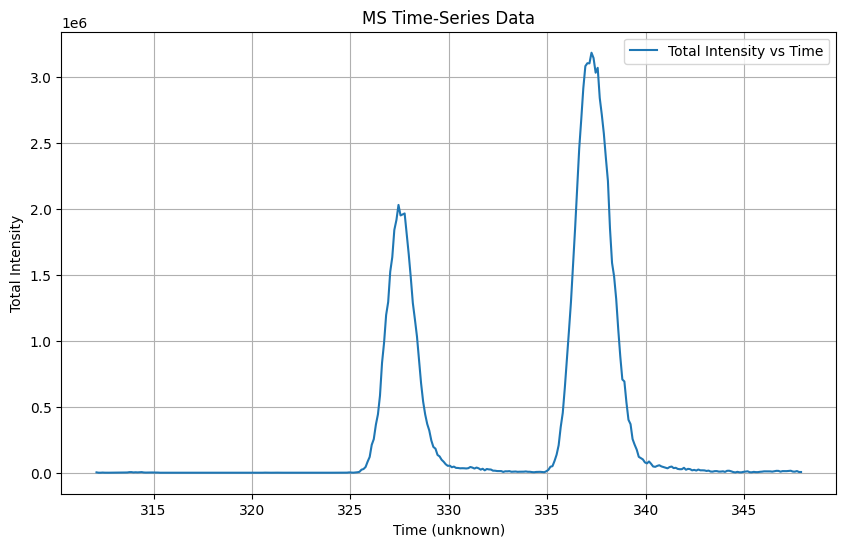

CDF file closed.


In [18]:
file_path = '../Data/LS_MS Data CDF/2015_SEP_18_LUBA_5T1_D10_MRM_TABL_M4_C13LR_LEU.CDF'
explore_cdf_file(file_path)

File loaded successfully.
File Format: NETCDF3_CLASSIC

=== Instrument-Related Metadata ===
dataset_completeness: C1+C2
ms_template_revision: 1.0.1
netcdf_revision: 2.3.2
languages: English
dataset_origin: 
dataset_owner: 
netcdf_file_date_time_stamp: 20150924132517+0000
experiment_title: Luba_6t1 d10 MRM Tabl m2 c13Lr
experiment_date_time_stamp: 20150919183344+0000
operator_name: 
source_file_reference: 2015_sep 18_Luba_6t1 d10 MRM Tabl m2 c13Lr
source_file_format: VG MassLynx
source_file_date_time_stamp: 20150919183344+0000
experiment_type: Centroided Mass Spectrum
sample_state: Other State
test_separation_type: No Chromatography
test_ms_inlet: Electrospray Inlet
test_ionization_mode: Electrospray Ionization
test_ionization_polarity: Positive Polarity
test_detector_type: Photomultiplier
test_resolution_type: Constant Resolution
test_scan_function: Selected Ion Detection
test_scan_direction: Up
test_scan_law: Linear
raw_data_mass_format: Float
raw_data_time_format: Float
raw_data_inte

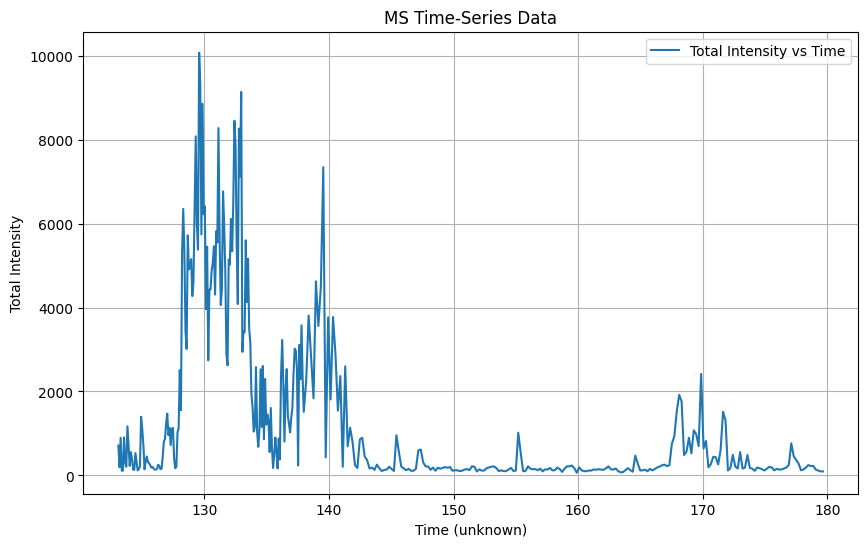

CDF file closed.


In [19]:
file_path = '../Data/LS_MS Data CDF/2015_SEP_18_LUBA_6T1_D10_MRM_TABL_M2_C13LR_GLN.CDF'
explore_cdf_file(file_path)

## Task 3. Data repositories exploration
Explore different posssibilities to acquire data. First check out the UCI repository (http://archive.ics.uci.edu/ml/datasets.html) datasets.

Use python to load following datasets from the UCI repository (we will use them for the sessions ahead):
1. http://archive.ics.uci.edu/ml/datasets/Computer+Hardware
2. http://archive.ics.uci.edu/ml/datasets/Wine

You have to check the description of the dataset to able to load it correctly and have all the meta-data and attributes loaded also.

Since datasets are all stored differently you might have to write slightly different loading procedures for every set.

Explore the data, which you have loaded. Visualize results.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo


pd.set_option('display.max_columns', None)


def load_uci_dataset(dataset_id, name):
    dataset = fetch_ucirepo(id=dataset_id)
    X = dataset.data.features
    y = dataset.data.targets
    df = pd.concat([X, y], axis=1)
    print(f"{name} Metadata:")
    print(dataset.metadata)
    print(f"\n{name} Variable Information:")
    print(dataset.variables)
    print(f"\nFirst 5 rows of the {name} dataset:")
    print(df.head())
    return df


def explore_dataset(df, name, target_col=None):
    print(f"\n{name} Dataset - Summary Statistics:")
    print(df.describe())
    print(f"\nMissing Values in {name}:")
    print(df.isnull().sum())
    if target_col:
        print(f"\n{target_col} Distribution:")
        print(df[target_col].value_counts())


def visualize_computer_hardware(df):
    plt.figure(figsize=(8, 6))
    plt.scatter(df['MYCT'], df['PRP'], alpha=0.5)
    plt.title('Cycle Time (MYCT) vs Published Relative Performance (PRP)')
    plt.xlabel('Cycle Time (nanoseconds)')
    plt.ylabel('Published Relative Performance')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.hist(df['PRP'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Published Relative Performance (PRP)')
    plt.xlabel('PRP')
    plt.ylabel('Frequency')
    plt.show()


def visualize_wine(df):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(df['Alcohol'], df['Color_intensity'], 
                          c=df['class'], cmap='viridis', alpha=0.6)
    plt.title('Alcohol vs Color Intensity by Class')
    plt.xlabel('Alcohol')
    plt.ylabel('Color Intensity')
    plt.colorbar(scatter, label='Class')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    df.boxplot(column='Alcohol', by='class', grid=False)
    plt.title('Alcohol Content by Wine Class')
    plt.suptitle('')
    plt.xlabel('Class')
    plt.ylabel('Alcohol')
    plt.show()

Wine Metadata:
{'uci_id': 109, 'name': 'Wine', 'repository_url': 'https://archive.ics.uci.edu/dataset/109/wine', 'data_url': 'https://archive.ics.uci.edu/static/public/109/data.csv', 'abstract': 'Using chemical analysis to determine the origin of wines', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 178, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1992, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C5PC7J', 'creators': ['Stefan Aeberhard', 'M. Forina'], 'intro_paper': {'ID': 246, 'type': 'NATIVE', 'title': 'Comparative analysis of statistical pattern recognition methods in high dimensional settings', 'authors': 'S. Aeberhard, D. Coomans, O. Vel', 'venue': 'Pattern Recognition', 'year': 1994, 'journal': None, 'DOI': '10.1016/0031-3203(94)90145-7',

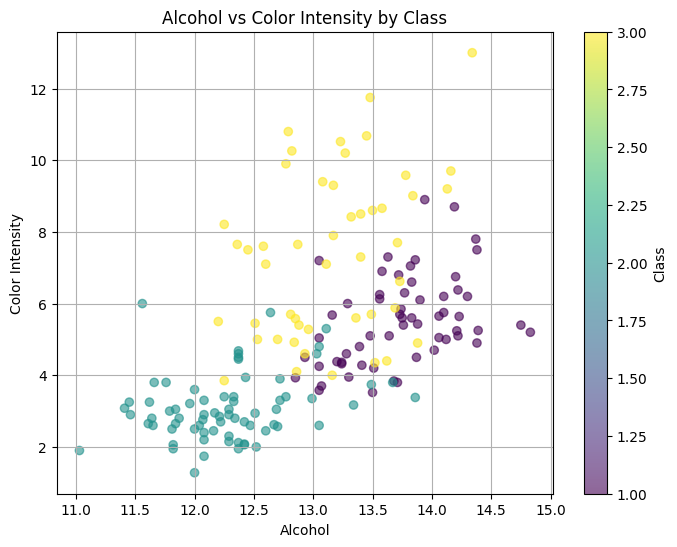

<Figure size 800x600 with 0 Axes>

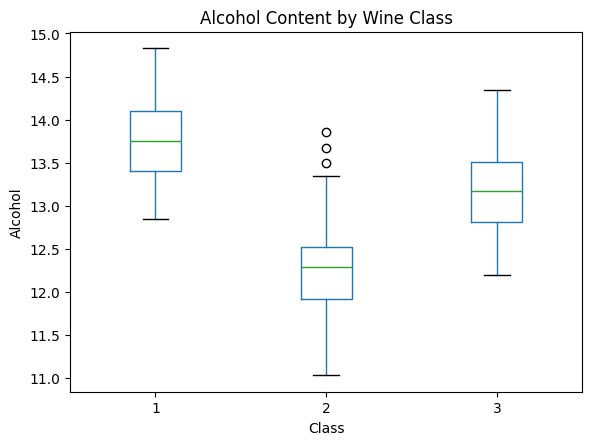

In [20]:
wine_df = load_uci_dataset(109, "Wine")

explore_dataset(wine_df, "Wine", target_col="class")

visualize_wine(wine_df)

Computer Hardware Metadata:
{'uci_id': 29, 'name': 'Computer Hardware', 'repository_url': 'https://archive.ics.uci.edu/dataset/29/computer+hardware', 'data_url': 'https://archive.ics.uci.edu/static/public/29/data.csv', 'abstract': 'Relative CPU Performance Data, described in terms of its cycle time, memory size, etc.', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 209, 'num_features': 10, 'feature_types': ['Integer'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1987, 'last_updated': 'Fri Oct 27 2023', 'dataset_doi': '10.24432/C5830D', 'creators': ['Jacob Feldmesser'], 'intro_paper': None, 'additional_info': {'summary': 'The estimated relative performance values were estimated by the authors using a linear regression method.  See their article (pp 308-313) for more details on how the relative performance values were set.', 'pu

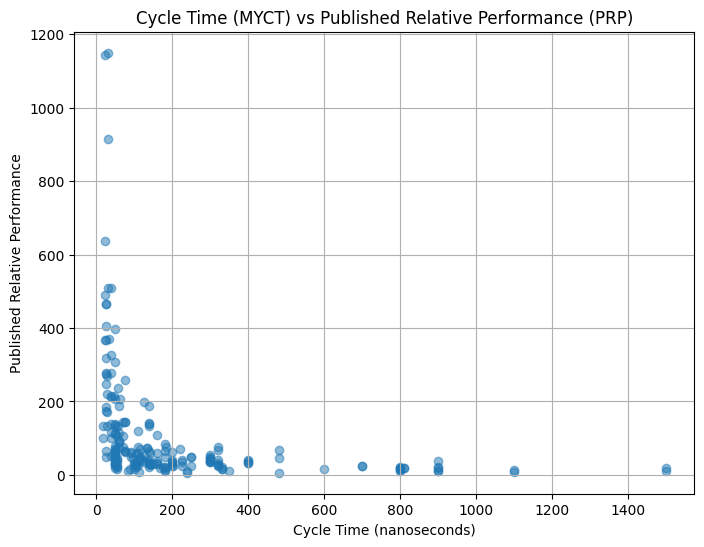

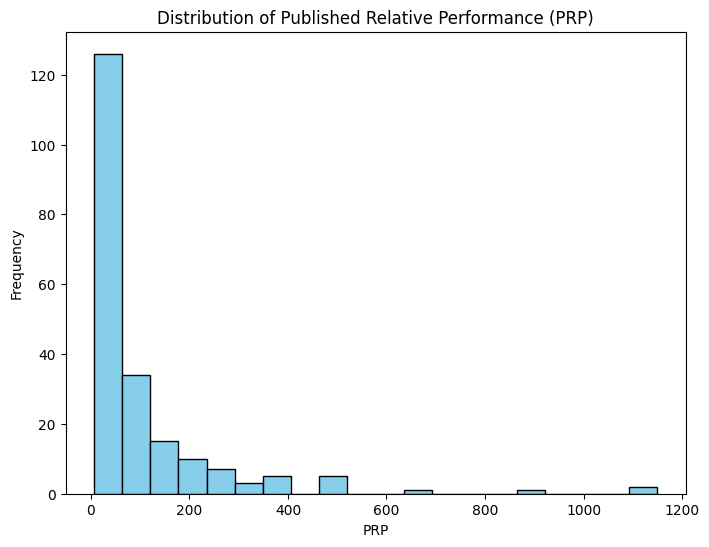

In [22]:
computer_df = load_uci_dataset(29, "Computer Hardware")

explore_dataset(computer_df, "Computer Hardware")

visualize_computer_hardware(computer_df)